# 8760 Notebook

### Imports

In [165]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cftime
import xarray as xr
import hvplot.xarray
import holoviews as hv
import panel as pn
from typing import List, Union, Tuple
from datetime import timedelta
from climakitae.explore.vulnerability import cava_data
from climakitae.util.utils import add_dummy_time_to_wl
from climakitae.explore.threshold_tools import (
    get_block_maxima,
    get_return_value,
    get_ks_stat,
    _get_fitted_distr,
    _calculate_return,
    _conf_int,
    _get_distr_func,
)
random.seed(42)

### Global Variables

In [2]:
# Putting locations into a DataFrame
locations = {
    "goleta": (34.486652, -119.894310),
    "iv": (34.427741, -119.855950),
    "sb_mountains": (34.518453, -119.799645),
    "valencia": (34.432468, -118.571098),
    "castaic": (34.492141, -118.605053),
    "lebec": (34.680102, -118.789246),
}

df = pd.DataFrame.from_dict(locations, orient='index', columns=['lat', 'lon']).reset_index()
df.rename(columns={'index': 'location'}, inplace=True)

In [3]:
# Santa Barbara area
sb = df.iloc[:3][['lat', 'lon']]
sb_locs = ['goleta', 'iv', 'sb_mountains']

# Santa Clarita area
sc = df.iloc[3:6][['lat', 'lon']]
sc_locs = ['valencia', 'castaic', 'lebec']

In [4]:
# Set params for 1-in-X calculations
one_in_x = np.array([10, 100])
event_duration = (1, 'day')
distr = 'gev'

### Plotting helper functions

In [5]:
def plot_retvals(calc_data: xr.Dataset, time_axis: bool = False) -> None:
    """
    Plot return values (or Julian day equivalents) from a calculation dataset.

    Args:
        calc_data (xr.Dataset): 
            An xarray Dataset containing dimensions including 'one_in_x', 
            'simulation', and 'location', with return value data.
        time_axis (bool, optional): 
            If True, divides the data by 24 to plot in Julian days.
            If False, plots the raw return values. Defaults to False.

    Returns:
        None
    """
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
    
    for j, xval in enumerate(calc_data.one_in_x.values):
        idx = np.where(calc_data['one_in_x'].values == xval)[0].item()
        data = calc_data.isel(one_in_x=idx)
        
        if time_axis:
            data = data / 24
        
        # Let xarray create the legend only on the first plot
        data.plot.line(
            ax=ax[j], hue='location', add_legend=(j == 0)
        )
        
        labels = [sim.item().split('_')[1] for sim in calc_data.simulation.values]
        ax[j].set_xticks(range(len(labels)))
        ax[j].set_xticklabels(labels, rotation=45, ha='right')
    
        ax[j].set_title(f"1-in-{xval} by GCM")
        ax[j].set_xlabel('GCM')
        
        if j == 0:
            if time_axis:
                ax[j].set_ylabel('Median Julian Day')
            else:
                ax[j].set_ylabel('Max Return Value')
        else:
            ax[j].set_ylabel('')
            
    plt.tight_layout()
    plt.show()

In [6]:
def plot_med_val_by_locs(calc_data: xr.Dataset, time_axis: bool = False) -> None:
    """
    Plot median return values by location for each return period.

    Args:
        calc_data (xr.Dataset):
            An xarray Dataset containing dimensions 'simulation', 'one_in_x', and 'location'.
            Expected to have return value data across simulations and locations.
        time_axis (bool, optional):
            If True, converts values from hours to Julian days by dividing by 24.
            If False, plots the raw return values. Defaults to False.

    Returns:
        None; just generates the figure
    """
    # Median return values
    med = calc_data.median(dim='simulation')
    
    one_in_x_vals = med['one_in_x'].values
    locations = med['location'].values
    
    n_groups = len(one_in_x_vals)
    n_locs = len(locations)
    
    bar_width = 0.1        # smaller width = visible space between bars
    group_width = n_locs * bar_width
    x = np.linspace(0, 0.5, n_groups)    # base x for each group
    
    fig, ax = plt.subplots(figsize=(6, 5))
    
    for i, loc in enumerate(locations):
        y = med.sel(location=loc).values
        if time_axis:
            y = y / 24
        offset = (i - (n_locs - 1) / 2) * bar_width  # center the group
        bar_positions = x + offset
        bars = ax.bar(bar_positions, y, width=bar_width - 0.01, label=str(loc))
    
        # Add text labels above each bar
        for xpos, height in zip(bar_positions, y):
            ax.text(xpos, height + 0.5, f'{height:.2f}', ha='center', va='bottom', fontsize=8)
    
    ymax = med.max().item()
    if time_axis:
        ymax = ymax / 24
    
    ax.set_ylim(top=ymax * 1.1)
    
    # Center group labels
    ax.set_xticks(x)
    ax.set_xticklabels([f"1-in-{v}" for v in one_in_x_vals])
    
    # Labels and formatting
    ax.set_xlabel('Return Period')
    if time_axis:
        ax.set_ylabel('Median Julian Day')
    else:
        ax.set_ylabel('1-in-X Max Value')
    ax.set_title('Median Return Values by Location')
    ax.legend(title='Location', loc='upper right', bbox_to_anchor=(1.35, 1))
    plt.show()

In [7]:
def plot_modified8760s(
    modified8760: xr.DataArray,
    figsize: tuple = (15, 8)
) -> None:
    """
    Plot modified 8760-hour data with two rows (one_in_x) and three columns (locations).

    Args:
        modified8760 (xr.DataArray):
            DataArray with dimensions ('hour_of_year', 'location', 'one_in_x').
        figsize (tuple, optional):
            Size of the entire figure. Defaults to (15, 8).

    Returns:
        None
    """
    plot = modified8760.plot.line(
        x='hour_of_year',
        row='one_in_x',
        col='location',
        sharey=False,
        aspect=2,
        figsize=figsize
    )

    # Adjust titles for each column
    for ax, loc in zip(plot.axs[0], modified8760.location.values):
        ax.set_title(loc, fontsize=16)

    # Adjust y-axis labels
    for row_i, one_in_x_val in enumerate(modified8760.one_in_x.values):
        for col_i, ax in enumerate(plot.axs[row_i]):
            if col_i == 0:
                # First column only: bold "1-in-X" label horizontally
                ax.set_ylabel(
                    rf"$\bf{{1\text{{-}}in\text{{-}}{int(one_in_x_val)}}}$" + "\n" + "degF",
                    fontsize=16,
                    rotation=0,
                    labelpad=40,
                    ha='center',
                    va='center',
                )
    
    plt.tight_layout()
    plt.show()

### Cleaning Helpers, `one_in_x` calculations, and Finding the Median Hours for 8760s

In [8]:
def clean_raw_data(raw_data: List[xr.Dataset], loc_names: List[str]) -> xr.Dataset:
    """
    Combines raw datasets together by new `location` dimension, creates a dummy time axis, and creates an hour-of-year coordinate.

    Args:
        raw_data (List[xr.Dataset]):
            A list of xarray Datasets, one for each location.
        loc_names (List[str]):
            A list of location names corresponding to the datasets.

    Returns:
        xr.Dataset:
            A single combined xarray Dataset with cleaned time and added 'hour_of_year' coordinate.
    """
    # raw_data, calc_data = cava_data_retval['raw_data'], cava_data_retval['calc_data']
    total_raw = xr.concat(raw_data, dim='location').assign_coords(location=loc_names)
    # total_calc = xr.concat(calc_data, dim='location').assign_coords(location=loc_names)
    total_raw = add_dummy_time_to_wl(total_raw)

    # Making new time axis without leap days
    total_raw['time'] = xr.cftime_range(
        start=f'{total_raw.time.dt.year[0].item()}-01-01', 
        periods=total_raw.sizes['time'], 
        freq='H', 
        calendar='noleap'
    )

    # Make new dimension for `hour_of_year`
    hour_of_year = (total_raw['time'].dt.dayofyear - 1) * 24 + total_raw['time'].dt.hour
    total_raw = total_raw.assign_coords(hour_of_year=hour_of_year)
    
    return total_raw

In [9]:
def get_one_in_x(
    da: xr.DataArray,
    one_in_x: Union[int, float],
    event_duration: Tuple[int, str],
    distr: str
) -> xr.DataArray:
    """
    Calculate the 1-in-X year return value for a given dataset and event duration.

    Args:
        da (xr.DataArray):
            Input xarray DataArray containing the data to analyze.
        one_in_x (Union[int, float]):
            Return period (e.g., 10 for 1-in-10 years) to calculate.
        event_duration (Tuple[int, str]):
            Duration grouping for block maxima, given as (amount, unit) 
            e.g., (1, 'hour'), (3, 'day').
        distr (str):
            Name of the statistical distribution to fit (e.g., 'gev', 'gumbel').

    Returns:
        xr.DataArray:
            DataArray of the 1-in-X return values calculated across simulations or points.
    """
    ams = get_block_maxima(
        da.squeeze(),
        extremes_type='max',
        groupby=event_duration,
        check_ess=False,
    ).squeeze()
    
    return get_return_value(
        ams,
        return_period=one_in_x,
        multiple_points=False,
        distr=distr,
    )

In [10]:
def find_med_hrs(
    raw_data: xr.Dataset,
    all_one_in_x: xr.Dataset
) -> xr.DataArray:
    """
    Finds the median hour-of-year of times with temperatures that fall between confidence interval bounds.

    Args:
        raw_data (xr.Dataset):
            Raw climate or observational data with dimensions including 'time', 'location', and 'simulation'.
        all_one_in_x (xr.Dataset):
            Dataset containing confidence interval bounds ('conf_int_lower_limit' and 'conf_int_upper_limit')
            for each 'one_in_x' return period.

    Returns:
        xr.DataArray:
            Median hour-of-year for each location, simulation, and return period ('one_in_x').
    """
    subset = raw_data.resample(time='1D').max()

    # Removing leap days
    subset['time'] = xr.cftime_range(
        start=f'{subset.time.dt.year[0].item()}-01-01', 
        periods=subset.sizes['time'], 
        freq='D', 
        calendar='noleap'
    )

    tmp = subset.where(
        (subset > all_one_in_x['conf_int_lower_limit']) &
        (subset < all_one_in_x['conf_int_upper_limit'])
    )
    
    hour_of_year = (tmp['time'].dt.dayofyear - 1) * 24 + tmp['time'].dt.hour
    tmp = tmp.assign_coords(hour_of_year=hour_of_year)

    med_hrs = tmp.groupby(["location", "simulation", "one_in_x"]).apply(
        lambda x: x.dropna(dim="time").hour_of_year.median()
    )
    
    med_hrs = med_hrs.assign_coords(simulation=med_hrs['simulation'].astype(str))
    med_hrs = med_hrs.assign_coords(location=med_hrs['location'].astype(str))

    # Re-order `med_hrs` to have the same location order as `raw_data` input
    med_hrs = med_hrs.reindex(location=raw_data.location.values)
    
    return med_hrs

In [11]:
def insert_at_hrs(
    median8760: xr.DataArray,
    med_hr: xr.DataArray,
    val: xr.DataArray,
    window: int = 1
) -> xr.DataArray:
    """
    Insert values into a DataArray at specific hours, with optional window.

    Args:
        median8760 (xr.DataArray):
            Array of baseline values with dimensions ('location', 'hour_of_year').
        med_hr (xr.DataArray):
            Target hours to modify, with dimensions ('location', 'one_in_x').
        val (xr.DataArray):
            Values to insert at the target hours, with dimensions ('location', 'one_in_x').
        window (int, optional):
            Number of hours before and after each med_hr to also replace.
            Defaults to 1.

    Returns:
        xr.DataArray:
            Mutated DataArray with dimensions ('location', 'one_in_x', 'hour_of_year').
    """
    broadcasted = xr.broadcast(val, median8760)[1]  # shape: (location, one_in_x, hour_of_year)

    result = broadcasted.copy()
    for offset in range(-window, window + 1):
        target_hr = med_hr + offset  # shape: (location, one_in_x)
        mask = broadcasted['hour_of_year'] == target_hr
        result = xr.where(mask, val, result)

    return result

# --- Calculations/Plotting Begin Here ---

### Grabbing appropriate datasets

In [12]:
### OPTION 1: Grab data via `cava_data`

# locs = [sb, sc]
# datas = []
# for loc in locs:
#     data = cava_data(
#         ## Set-up
#         loc, # select a single location
#         variable="Air Temperature at 2m",
#         units="degF", # change units
#         downscaling_method="Dynamical",  # WRF data 
#         approach="Warming Level",  
#         warming_level=2.0,
#         wrf_bias_adjust=False, # return bias adjusted WRF models
    
#         # These are passed in but the export method is 'raw', so no calculation is done
#         # This is because `cava_data` doesn't currently provide lower/upper CI limits for the bootstrapped 1-in-X 'gev' distributions
#         metric_calc='max',
#         one_in_x=[10, 100],
#         event_duration=(1, 'day'),
        
#         ## Export
#         export_method="raw",
#         file_format="NetCDF",
#     )
#     datas.append(data)

# sb_data, sc_data = datas

In [13]:
### OPTION 2: Read in saved files
sb_das = [
    'one_in_10-100_temperature_raw_data_34495N_-119882W.nc',
    'one_in_10-100_temperature_raw_data_34434N_-11987W.nc',
    'one_in_10-100_temperature_raw_data_3452N_-119782W.nc'
]
sc_das = [
    'one_in_10-100_temperature_raw_data_34425N_-118559W.nc',
    'one_in_10-100_temperature_raw_data_34492N_-118616W.nc',
    'one_in_10-100_temperature_raw_data_34695N_-118788W.nc',
]

# Reading in DataArrays
sb_data = xr.open_mfdataset(sb_das, concat_dim="location", combine="nested").to_array().squeeze("variable")
sb_data.attrs['frequency'] = 'hourly'
sb_data = sb_data.assign_coords({'location': sb_locs}).compute()
sc_data = xr.open_mfdataset(sc_das, concat_dim="location", combine="nested").to_array().squeeze("variable")
sc_data.attrs['frequency'] = 'hourly'
sc_data = sc_data.assign_coords({'location': sc_locs}).compute()

### Cleaning data and generating 1-in-X calculations

In [14]:
# Cleaning the raw data from `cava_data`
clean_raw_data_sb = clean_raw_data(sb_data, sb_locs)
clean_raw_data_sc = clean_raw_data(sc_data, sc_locs)

In [15]:
%%time
# Calculating the 1-in-X return values, and lower + upper CIs, for SB locations
all_one_in_x_sb = get_one_in_x(clean_raw_data_sb, one_in_x, event_duration, distr)
calc_data_sb = all_one_in_x_sb['return_value']

CPU times: user 2min 1s, sys: 112 ms, total: 2min 1s
Wall time: 2min 1s


In [16]:
%%time
# Calculating the 1-in-X return values, and lower + upper CIs, for SC locations
all_one_in_x_sc = get_one_in_x(clean_raw_data_sc, one_in_x, event_duration, distr)
calc_data_sc = all_one_in_x_sc['return_value']

CPU times: user 1min 44s, sys: 24.1 ms, total: 1min 44s
Wall time: 1min 44s


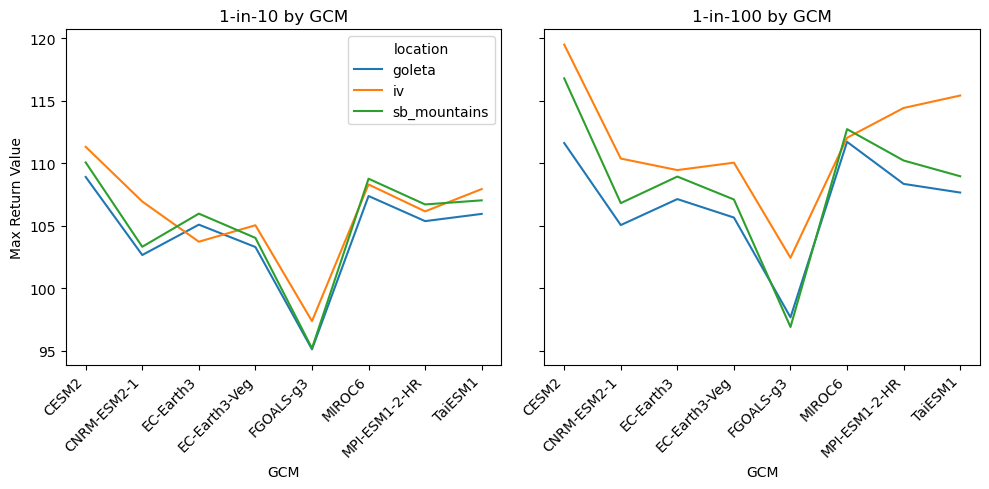

In [17]:
# Plotting the 1-in-X values by simulation for Santa Barbara locations
plot_retvals(calc_data_sb)

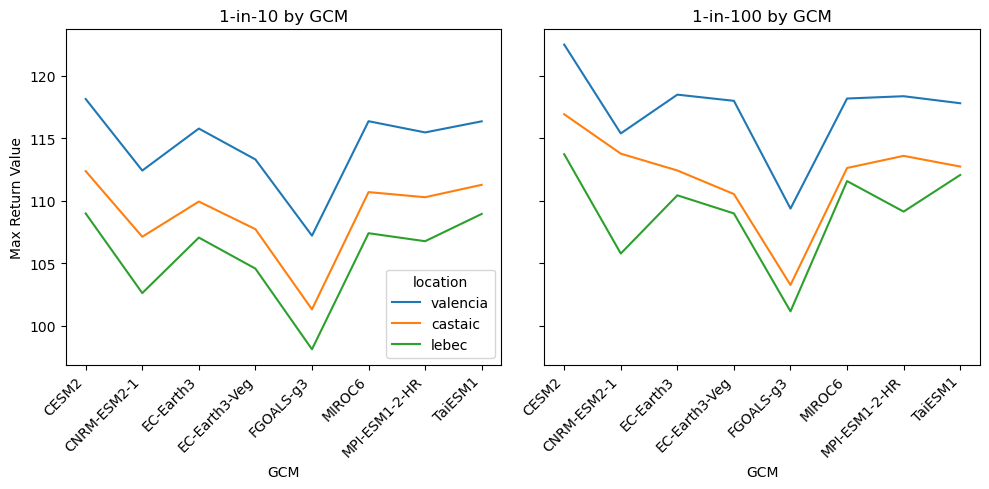

In [18]:
# Plotting the 1-in-X values by simulation for Santa Clarita locations
plot_retvals(calc_data_sc)

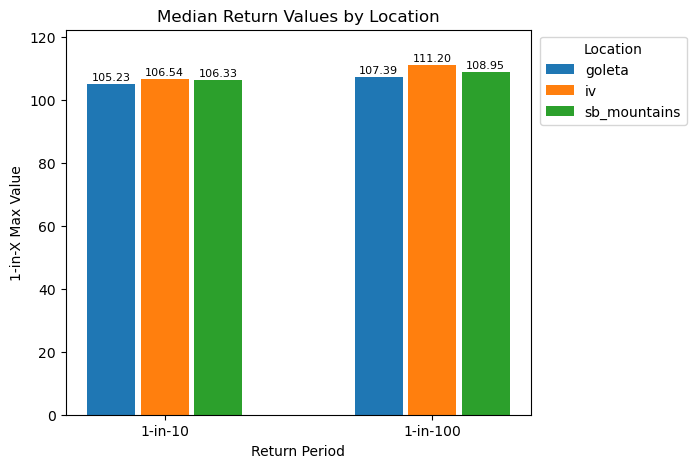

In [19]:
# Finding the median of the above plots along simulation dimension
plot_med_val_by_locs(calc_data_sb)

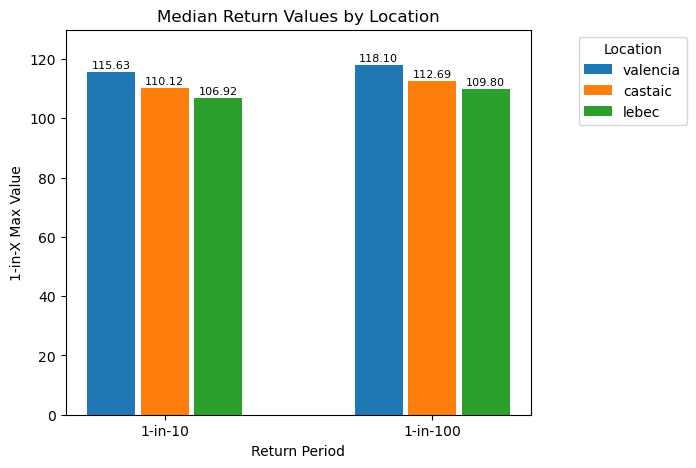

In [20]:
plot_med_val_by_locs(calc_data_sc)

---

### Inserting `time` amount of 1-in-X timesteps into 8760s

#### Helper Functions

In [174]:
def make_clean_daily(raw_data: xr.DataArray) -> xr.DataArray:
    """
    Resamples hourly data to daily maximum values and assigns a 'hour_of_year' coordinate
    based on the resulting no-leap calendar day timestamps.

    Parameters:
        raw_data (xr.DataArray): Hourly data with a 'time' dimension.

    Returns:
        xr.DataArray: Daily max data with updated 'time' and 'hour_of_year' coordinates.
    """
    # Resample to daily max
    daily = raw_data.resample(time='1D').max()

    # Reset time to a clean noleap calendar range starting Jan 1 of first year
    start_year = daily.time.dt.year[0].item()
    daily['time'] = xr.cftime_range(
        start=f'{start_year}-01-01',
        periods=daily.sizes['time'],
        freq='D',
        calendar='noleap'
    )

    # Assign hour_of_year (since it's daily, this will be 0, 24, 48, ...)
    # hour_of_year = (daily['time'].dt.dayofyear - 1) * 24
    hour_of_year = (daily['time'].dt.dayofyear - 1) * 24 + daily['time'].dt.hour
    daily = daily.assign_coords(hour_of_year=hour_of_year)

    return daily

In [175]:
def combine_ds(daily_da: xr.DataArray, one_in_x_da: xr.Dataset) -> xr.Dataset:
    """
    Combines a daily DataArray with confidence interval bounds from a dataset into a single Dataset.

    Parameters:
        daily_da (xr.DataArray): Daily values (e.g. temperature or metric output).
        one_in_x_da (xr.Dataset): Dataset containing 'conf_int_lower_limit' and 'conf_int_upper_limit'.

    Returns:
        xr.Dataset: Dataset with three aligned DataArrays: 'vals', 'lower', and 'upper'.
    """
    # Align daily data with confidence bounds
    lower = xr.broadcast(daily_da, one_in_x_da['conf_int_lower_limit'])[1]
    upper = xr.broadcast(daily_da, one_in_x_da['conf_int_upper_limit'])[1]

    # Combine into a new Dataset
    combined = xr.Dataset({
        'vals': daily_da,
        'lower': lower,
        'upper': upper
    })

    return combined

In [176]:
def find_valid_times(timeseries: xr.Dataset) -> np.ndarray:
    """
    Finds all times where the 'vals' are strictly between the 'lower' and 'upper' bounds.

    Parameters:
        timeseries (xr.Dataset): Dataset containing 'vals', 'lower', and 'upper' variables with a 'time' dimension.
        t (int): Currently unused, but could represent window size or context for future filtering.

    Returns:
        np.ndarray: Array of time values where the condition is met.
    """
    # Identify time points where 'vals' fall between 'lower' and 'upper'
    valid_mask = (timeseries['vals'] > timeseries['lower']) & (timeseries['vals'] < timeseries['upper'])
    
    # Extract valid time values
    valid_times = timeseries['time'].where(valid_mask).dropna('time').time.values

    return valid_times

In [177]:
def gather_valid_times(ds: xr.Dataset) -> pd.DataFrame:
    """
    Applies `find_valid_times` to each (location, simulation, one_in_x) group in the dataset,
    and returns a DataFrame of valid times per group.

    Parameters:
        ds (xr.Dataset): Input dataset with dimensions including 'location', 'simulation', 'one_in_x', and 'time'.
        t (int): Window size passed to `find_valid_times`.

    Returns:
        pd.DataFrame: A DataFrame with columns: location, simulation, one_in_x, and valid_times (as np.ndarray).
    """
    results = []
    grouped = ds.squeeze().groupby(['location', 'simulation', 'one_in_x'])

    for (loc, sim, oneinx), subset in grouped:
        valid = find_valid_times(subset)
        results.append({
            'location': loc,
            'simulation': sim,
            'one_in_x': oneinx,
            'valid_times': valid
        })

    return pd.DataFrame(results)

In [178]:
def extract_event_windows(timeseries: xr.DataArray, df: pd.DataFrame, t: int) -> xr.DataArray:
    """
    Extracts non-overlapping time windows of length (2t + 1) days around valid event timestamps,
    for a specific (location, simulation, one_in_x) combination.

    Parameters:
        timeseries (xr.DataArray): Time series with dimensions including 'time'.
        df (pd.DataFrame): DataFrame containing valid event timestamps in 'valid_times'.
        t (int): Half-window size in days (default is 3, for a 7-day window).

    Returns:
        xr.DataArray: Median of all extracted windows with time replaced by relative indices.
    """
    # Filter dataframe for matching metadata
    df_subset = df[
        (df['location'] == timeseries.location.item()) &
        (df['simulation'] == timeseries.simulation.item()) &
        (df['one_in_x'] == timeseries.one_in_x.item())
    ]

    # Get valid timestamps
    event_times = np.atleast_1d(df_subset.valid_times.item())

    # Define time slices: [t days before, t days after] each event
    time_slices = [
        slice(dt - timedelta(days=t), dt + timedelta(days=t + 1) - timedelta(hours=1))
        for dt in event_times
    ]

    # Extract windows and normalize time axis
    windows = [
        timeseries.sel(time=ts).assign_coords(time=np.arange(timeseries.sel(time=ts).sizes['time']))
        for ts in time_slices
    ]

    # Take median across all extracted windows
    return xr.concat(windows, dim='window').median(dim='window')


In [179]:
def generate_data_to_insert(
    times_to_insert_at: xr.DataArray,
    clean_raw_data: xr.DataArray,
    metadata_df: pd.DataFrame,
    t: int
) -> xr.DataArray:
    """
    Extracts event-based time windows from raw data using group-wise metadata and computes
    the median pattern to insert for each (location, one_in_x) across simulations.

    Parameters:
        times_to_insert_at (xr.DataArray): Time DataArray with shape matching metadata (used to align with raw data).
        clean_raw_data (xr.DataArray): Full daily/hourly input data.
        metadata_df (pd.DataFrame): DataFrame containing valid times per group.
        t (int): Half-window size in days for extraction (default: 3).

    Returns:
        xr.DataArray: Median event response per group, collapsed across simulations.
    """
    # Broadcast clean raw data to shape of insertion times
    total_da = xr.broadcast(times_to_insert_at, clean_raw_data)[1]

    # Extract and reduce across simulations
    to_insert = (
        total_da.squeeze()
        .groupby(['location', 'simulation', 'one_in_x'])
        .apply(lambda timeseries: extract_event_windows(timeseries, metadata_df, t))
        .median(dim='simulation')
    )
    return to_insert

In [180]:
def insert_data(
    to_insert: xr.DataArray,
    center_time: int,
    orig_data: xr.DataArray,
    t: int
) -> xr.DataArray:
    """
    Inserts a short time window (`to_insert`) into a copy of the original data array,
    centered at a specified hour index.

    Parameters:
        to_insert (xr.DataArray): Data to insert (length should be 24 * (2t + 1)).
        center_time (int): Center index (in hours) for the insertion.
        orig_data (xr.DataArray): The full-length time series to modify.
        t (int): Half-window size in days.

    Returns:
        xr.DataArray: Copy of `orig_data` with `to_insert` injected into the specified time window.
    """
    start = int(center_time) - 24 * t
    end = int(center_time) + 24 * (t + 1)
    
    result = orig_data.copy()
    result[start:end] = to_insert

    return result

In [192]:
def plot_modified8760s(
    modified8760: xr.DataArray,
    figsize: tuple = (15, 8)
) -> None:
    """
    Plot modified 8760-hour data with two rows (one_in_x) and three columns (locations).

    Args:
        modified8760 (xr.DataArray):
            DataArray with dimensions ('hour_of_year', 'location', 'one_in_x').
        figsize (tuple, optional):
            Size of the entire figure. Defaults to (15, 8).

    Returns:
        None
    """
    plot = modified8760.plot.line(
        x='hour_of_year',
        row='one_in_x',
        col='location',
        sharey=False,
        aspect=2,
        figsize=figsize
    )

    # Adjust titles for each column
    for ax, loc in zip(plot.axs[0], modified8760.location.values):
        ax.set_title(loc, fontsize=16)

    # Adjust y-axis labels
    for row_i, one_in_x_val in enumerate(modified8760.one_in_x.values):
        for col_i, ax in enumerate(plot.axs[row_i]):
            if col_i == 0:
                # First column only: bold "1-in-X" label horizontally
                ax.set_ylabel(
                    rf"$\bf{{1\text{{-}}in\text{{-}}{int(one_in_x_val)}}}$" + "\n" + "degF",
                    fontsize=16,
                    rotation=0,
                    labelpad=40,
                    ha='center',
                    va='center',
                )

    # plt.xlim(left=4000, right=6000)
    plt.tight_layout()
    plt.show()

#### Finding the data to insert, when to insert it, and the median 8760 to insert it into

In [181]:
# Make cleaned datasets of each location area, and combine that with 1-in-X confidence interval values by location
sb_daily_ds = combine_ds(make_clean_daily(clean_raw_data_sb), all_one_in_x_sb)
sc_daily_ds = combine_ds(make_clean_daily(clean_raw_data_sc), all_one_in_x_sc)

In [182]:
# Setting param for number of +/- number of days to 'ramp up' and 'ramp down' by
t = 7

In [183]:
# Getting the valid times to subset around from the original data
sb_df = gather_valid_times(sb_daily_ds)
sc_df = gather_valid_times(sc_daily_ds)

In [184]:
# Finding the median 8760s to insert into
median8760_sb = clean_raw_data_sb.groupby('hour_of_year').median().median(dim='simulation').squeeze()
median8760_sc = clean_raw_data_sc.groupby('hour_of_year').median().median(dim='simulation').squeeze()

In [185]:
# Finding when to insert them
times_to_insert_at_sb = find_med_hrs(clean_raw_data_sb, all_one_in_x_sb).median(dim='simulation')
times_to_insert_at_sc = find_med_hrs(clean_raw_data_sc, all_one_in_x_sc).median(dim='simulation')

# MODIFYING WHEN TO INSERT (this is if you want all the 1-in-X events to be inserted at the same time
# new_times = times_to_insert_at_sb.copy()
# new_times[:] = 6*30*24+1
# # new_times.loc[dict(location='goleta', one_in_x=10)] = 6*30*24+1

In [186]:
# Finding the values to insert into median 8760
to_insert_vals_sb = generate_data_to_insert(
    times_to_insert_at_sb,
    clean_raw_data_sb,
    sb_df,
    t
)
to_insert_vals_sc = generate_data_to_insert(
    times_to_insert_at_sc,
    clean_raw_data_sc,
    sc_df,
    t
)

In [190]:
# Broadcasting the median 8760s with 1-in-X dimension
sb_broadcasted = xr.broadcast(times_to_insert_at_sb, median8760_sb)[1]
sc_broadcasted = xr.broadcast(times_to_insert_at_sc, median8760_sc)[1]

# Creating the modified 8760s
modified8760_sb = xr.apply_ufunc(
    insert_data,
    to_insert_vals_sb,
    times_to_insert_at_sb,
    # tmptmp, # times_to_insert_at_sb,
    sb_broadcasted,
    input_core_dims=[['time'], [], ['hour_of_year']],
    output_core_dims=[['hour_of_year']],
    kwargs={'t': t},
    vectorize=True
)

modified8760_sc = xr.apply_ufunc(
    insert_data,
    to_insert_vals_sc,
    times_to_insert_at_sc,
    sc_broadcasted,
    input_core_dims=[['time'], [], ['hour_of_year']],
    output_core_dims=[['hour_of_year']],
    kwargs={'t': t},
    vectorize=True
)

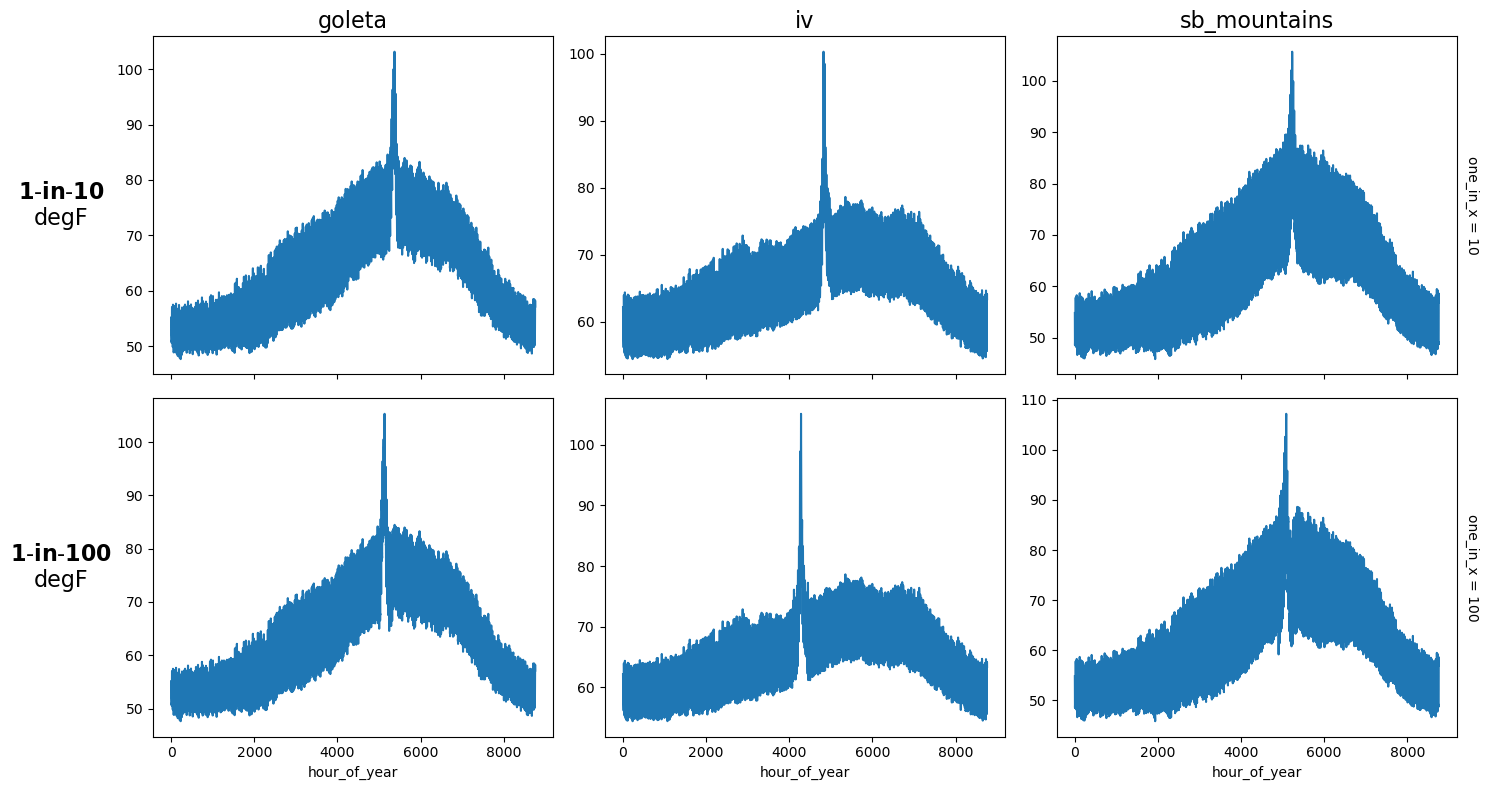

In [191]:
plot_modified8760s(modified8760_sb)

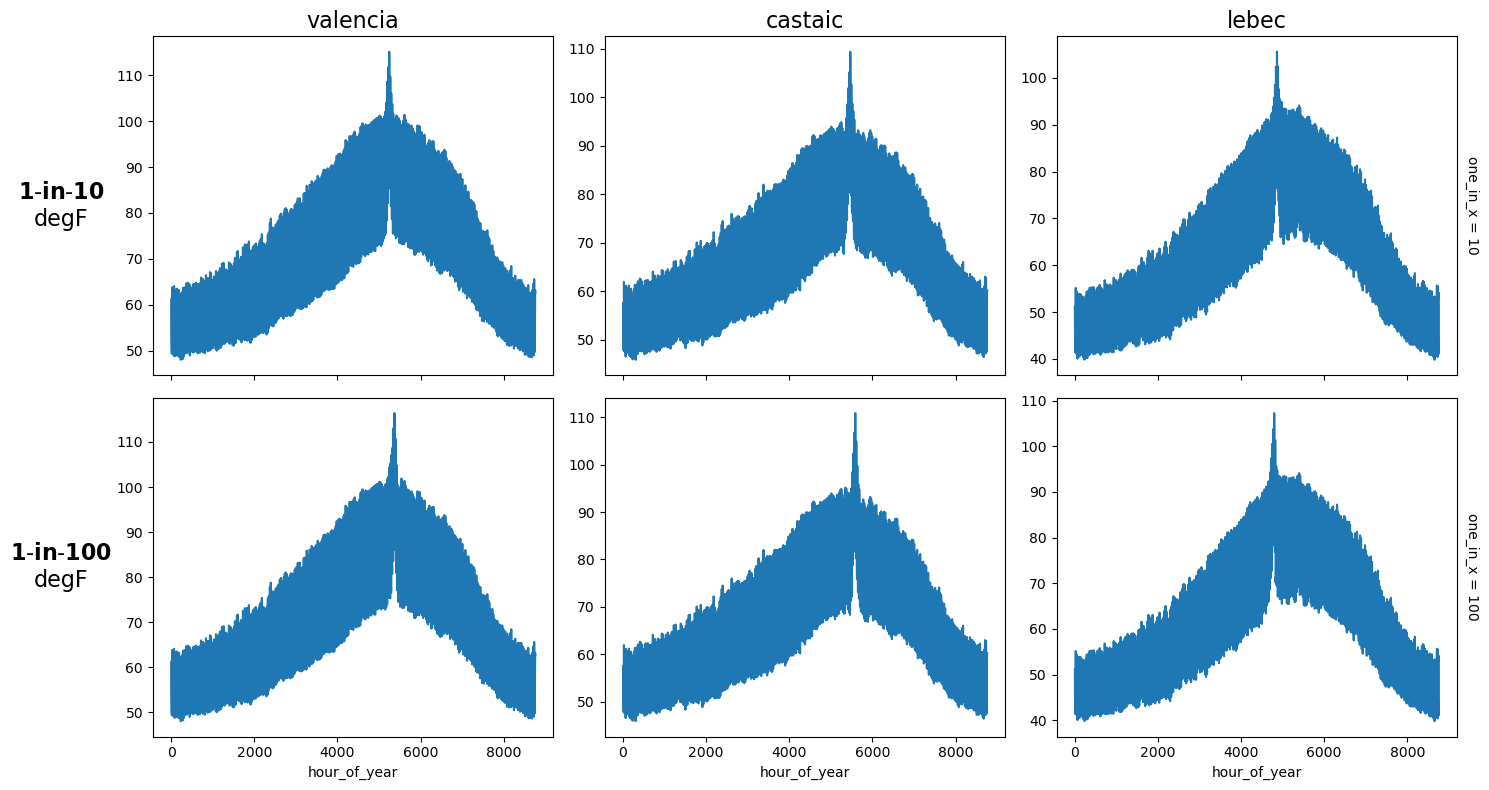

In [193]:
plot_modified8760s(modified8760_sc)

---

### Alt Idea: Look at all 8760s and median along time, not amongst values

In [ ]:
def dum(x):
    import pdb; pdb.set_trace()
    return x

In [ ]:
first_year = int(ds.time.dt.year.values.max())
first_year_ds = ds.sel(time=ds.time.dt.year == first_year)

In [ ]:
def new_test(timeseries, t):

    # 1. Identify valid times
    mask = (timeseries['vals'] > timeseries['lower']) & (timeseries['vals'] < timeseries['upper'])
    valid_times = timeseries['time'].where(mask).dropna('time').time.values

    import pdb; pdb.set_trace()
    
    # # 2. Build all time ranges at once
    # time_slices = [
    #     slice(dt - pd.Timedelta(days=t), dt + pd.Timedelta(days=t))
    #     for dt in valid_times
    # ]
    
    # # 3. Use a list comprehension instead of for loop
    # subs = [
    #     timeseries.sel(time=ts).assign_coords(time=np.arange(timeseries.sel(time=ts).sizes['time']))
    #     for ts in time_slices
    # ]
    
    # # 4. Stack and take median
    # mini_insert = xr.concat(subs, dim='window').median(dim='window')
    # result = mini_insert['vals']
    return result

In [ ]:
res1 = ds.squeeze().groupby(['location', 'simulation', 'one_in_x']).apply(lambda timeseries: new_test(timeseries, t))

In [ ]:
one_yr = ds.squeeze().isel(location=0)
for sim in one_yr.simulation.values:
    print(sim)
    one_year = one_yr.sel(simulation=sim, one_in_x=10)
    mask = (one_year['vals'] > one_year['lower']) & (one_year['vals'] < one_year['upper'])
    # one_year_times = one_year['time'].where(mask).dropna('time').time.values
    print(one_year_times)
    # print(mask)

In [ ]:
mask = (one_year['vals'] > one_year['lower']) & (one_year['vals'] < one_year['upper'])
one_year_times = one_year['time'].where(mask).dropna('time').time.values

In [ ]:
one_year

In [ ]:
ds.groupby('time.year').apply(dum)

In [ ]:
# Find 8760s that are within the bounds
ds.groupby('hour_of_year').apply(dum)